# Calibrating Pastas models
*R.A. Collenteur, University of Graz*

After a model is constructed, the model parameters can be estimated using the `ml.solve` method. It can (and will) happen that the model fit after solving is not as good as expected. This may be the result of the settings that are used to solve the model or the way the model was constructed. In this notebook common pitfalls and various tips and tricks that may help to improve the calibration of Pastas models are shared. 

In general, the following strategy is advised to solve problems with the parameter estimation:

1. Check the input time series and solve settings
2. Change the initial parameters,
3. Change the model structure,
4. Change the solve method.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

ps.show_versions()
ps.set_log_level("ERROR")

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.21.2
Scipy version: 1.7.3
Pandas version: 1.3.5
Pastas version: 0.20.0b
Matplotlib version: 3.5.0


## Loading the data 
In the following code-block some example data is loaded. It is good practice to visualize all time series before creating the time series model.

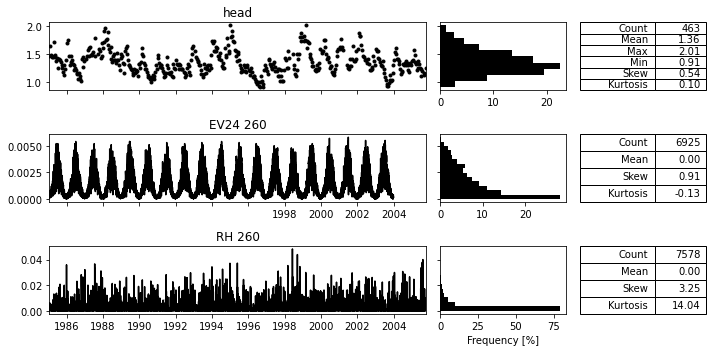

In [2]:
head = pd.read_csv("../data/B32C0639001.csv",  parse_dates=['date'], 
                   index_col='date').squeeze().loc["1985":]

# Make this millimeters per day
evap = ps.read_knmi("../data/etmgeg_260.txt", variables="EV24").series.loc["1985":"2003"]
rain = ps.read_knmi("../data/etmgeg_260.txt", variables="RH").series.loc["1985":"2005"]

ps.plots.series(head, [evap, rain]);

## Make a model

Given the data above we create a Pastas model with a non-linear recharge model (`ps.FlexModel`) and a constant to simulate the groundwater level. We'll use this model to show how we may analyse different types of problems and how to solve them. 

In [3]:
ml = ps.Model(head)
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml.add_stressmodel(rm)

## Calibrating a model
In the above code-block a Pastas model was created, but not yet solved. To solve the model we call `ml.solve()`. This method has quite a few options (see also the docstring of the method) that influence the model calibration, for example:

- `tmin/tmax`: select the time period used for calibration
- `noise`: use a noise model to model the residuals or not
- `fit_constant`: fit the constant as a parameter or not
- `warmup`: length of the warmup period
- `solver`: the solver that is used to estimate parameters

We start without providing any arguments to the solve method.

Fit report head                           Fit Statistics
nfev    41                     EVP                 29.05
nobs    463                    R2                   0.29
noise   True                   RMSE                 0.17
tmin    1985-01-15 00:00:00    AIC              -2245.64
tmax    2005-10-14 00:00:00    BIC              -2212.53
freq    D                      Obj                  1.75
warmup  3650 days 00:00:00     ___                      
solver  LeastSquares           Interp.                No

Parameters (8 optimized)
                 optimal       stderr     initial   vary
rch_A          42.860452      ±15.49%    2.373862   True
rch_n           1.004526      ±19.06%    1.000000   True
rch_a           8.629918      ±38.82%   10.000000   True
rch_srmax     212.990911  ±802401.80%  250.000000   True
rch_lp          0.250000        ±nan%    0.250000  False
rch_ks       1562.001002  ±988609.79%  100.000000   True
rch_gamma       1.232058      ±33.04%    2.000000   True
rch_k

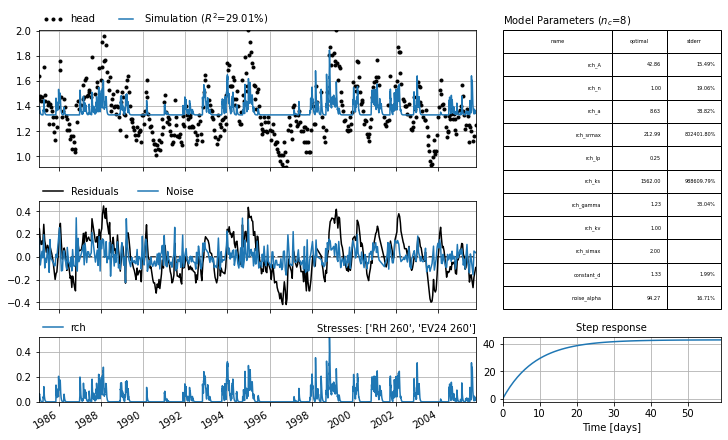

In [4]:
#ml.solve?  ## Run this to see other solve options
ml.solve()
ml.plots.results(figsize=(10,6));

The fit report and the Figure above show that the model is not that great. The parameters have large standard errors, the goodness-of-fit metrics are not that high, and the simulated time series shows a very different behavior to the observed groundwater level. 

## Checking the explanatory time series and solve settings

A common pitfall is that there is a problem with the explanatory time series (e.g., precipitation, pumping discharge). This should be the first thing to check when the model fit is not as good as expected. 

- **Length of Time Series:** The time series should in principle be available for the entire period of calibration, 
- **Warmup Period:** For some models it is necessary that the time series are also available before the calibration period, during the warmup period. This is for example the case with the non-linear recharge models (e.g., FlexModel, Berendrecht).
- **Units of Time Series (1):** While Pastas is in principle unitless, the units of the time series can impact the model calibration. For example, a pumping discharge provided in m$^3$/day may lead to very small parameter values ('Gamma_A') that are harder to esimate. If you end up with very small parameters for the gain parameter, it may help to rescale the input time series.
- **Units of Time Series (2):** The initial parameters and bounds for the non-linear recharge models are set for precipitation and evaporaton time series provided in mm/day. Using these models with time series in m/day will give bad results.
- **Normalization of Time Series:** Sometimes it can help to normalize the expanatory time series. For example, when using a river level that is high above a certain datum (e.g. tens of meters), it may help to subtract the mean water level from the time series first.

In the example model, many of these things are happening. First, the precipitation time series are not available for the entire calibration period. Secondly, because a non-linear model is applied, we need to to have precipitation and evaporation data before the calibration period starts (typically about one year is enough). We should therefore shorten the calibration period by using to 1986-2003. Note that we use 3650 days for the warmup period (`warmup=3650` is the default), the last 365 days of which now has real precipitation and evaporation data . For the other 9 years the mean flux is used. Finally, the non-linear model requires the evaporation and precipitation in mm/day (unless we want to manually set all parameter bounds). 

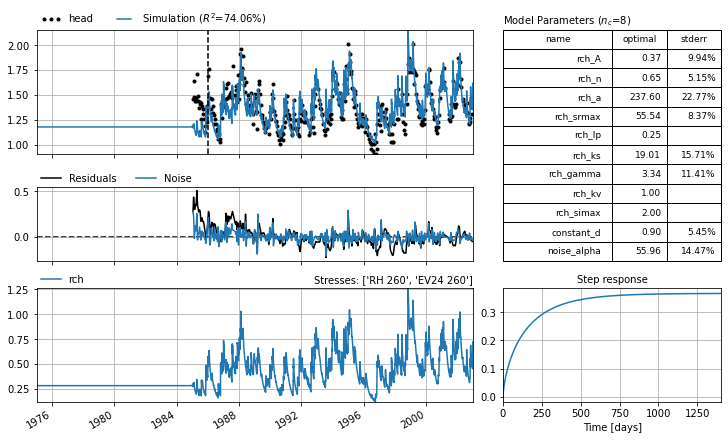

In [5]:
ml = ps.Model(head)
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain * 1e3, evap * 1e3, recharge=rch, rfunc=ps.Gamma, name="rch")
ml.add_stressmodel(rm)

ml.solve(tmin="1986", tmax="2003", report=False)
axes = ml.plots.results(tmin="1975", figsize=(10,6))  # Use tmin=1975 to show warmup period
axes[0].axvline("1986", c="k", linestyle="--");  # Start of calibration

Changing the explanatory time series and using the correct calibration period definitely improve the model fit in this example. Changing the explanatory time series a bit generally helps to resolve many issues with the calibration. If this does not work, we may try to help the solver a bit.

## Improving initial parameters
Although Pastas tries to set sensible initial parameters when constructing a model, it occurs that the initial parameters set by Pastas are not a great place to start the search for the optimal parameters. In this case, it may be tried to manually adapt the initial parameters using the `ml.set_parameter` as follows:

In [6]:
ml.set_parameter("rch_n", initial=15)  # Clearly wrong, just for educational purposes
ml.solve(noise=True, tmin="1986", tmax="2003", report=True)

Fit report head                         Fit Statistics
nfev    33                     EVP               47.53
nobs    376                    R2                 0.47
noise   True                   RMSE               0.16
tmin    1986-01-01 00:00:00    AIC            -1651.98
tmax    2003-01-01 00:00:00    BIC            -1620.54
freq    D                      Obj                2.23
warmup  3650 days 00:00:00     ___                    
solver  LeastSquares           Interp.              No

Parameters (8 optimized)
                optimal      stderr     initial   vary
rch_A          0.208079     ±16.75%    0.612817   True
rch_n          6.094436     ±25.75%   15.000000   True
rch_a         22.169024     ±28.63%   10.000000   True
rch_srmax    517.340930  ±10426.15%  250.000000   True
rch_lp         0.250000       ±nan%    0.250000  False
rch_ks       586.721730      ±0.00%  100.000000   True
rch_gamma      0.265773      ±0.00%    2.000000   True
rch_kv         1.000000       ±nan%    

Often we do not know what good initial parameters are, but we do get a bad fit, like with this initial value for `rch_n` above. While solving the model with a noise model is recommended, it does make the parameter estimation more difficult and more sensitive to the initial parameter values. One solution that often helps is to first solve the model without a noise model, and then solve the model with a noise model but without re-initializing the parameters. 

By default the parameters are initialized upon each solve, such that each time we call solve we obtain the same result. By setting `initial=False` we prevent the re-initialisation and use the optimal parameters as initial parameters. This can be done as follows:

Fit report head                      Fit Statistics
nfev    46                     EVP            82.19
nobs    376                    R2              0.82
noise   True                   RMSE            0.09
tmin    1986-01-01 00:00:00    AIC         -2112.20
tmax    2003-01-01 00:00:00    BIC         -2080.76
freq    D                      Obj             0.65
warmup  3650 days 00:00:00     ___                 
solver  LeastSquares           Interp.           No

Parameters (8 optimized)
                optimal   stderr     initial   vary
rch_A          0.344044   ±9.93%    0.346475   True
rch_n          0.683988   ±5.38%    0.948183   True
rch_a        198.447053  ±22.10%  127.651158   True
rch_srmax     61.849216   ±9.66%   32.000005   True
rch_lp         0.250000    ±nan%    0.250000  False
rch_ks        31.817675  ±14.48%  196.611847   True
rch_gamma      3.197036  ±11.88%    0.868882   True
rch_kv         1.000000    ±nan%    1.000000  False
rch_simax      2.000000    ±nan%    2.

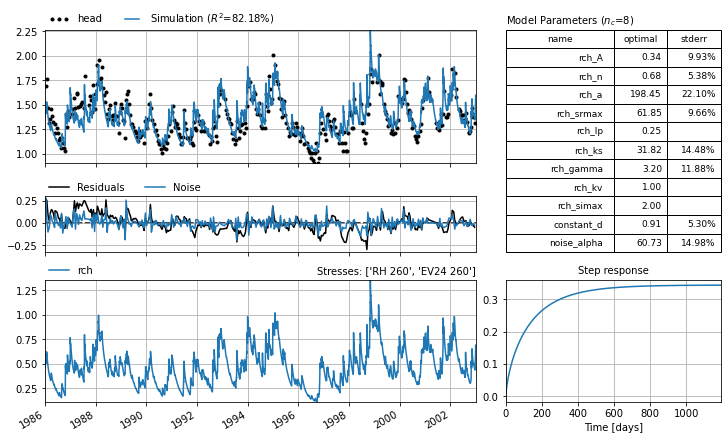

In [7]:
ml.solve(noise=False, report=False, tmin="1986", tmax="2003")  # First solve without noise model
ml.solve(noise=True, initial=False, tmin="1986", tmax="2003", report=True)  # Then solve with noise model, but do not initialize the parameters
axes = ml.plots.results(figsize=(10,6))

After solving the model without a noise model (providing the solver an easier problem), we solve again with the parameter estimated from the solve without a noise model. This generally works well. We may also choose to fix parameters that are hard to estimate, perhaps because they are correlated to other parameters, to certain values.

## Changing the model structure
At this point, one might start to think that the bad fit has something to do with the model structure. This could off course be an explanatory time series that is missing, but let's assume that is not the case. One thing that might help is too change the response function. This can either be from a complicated function to a simpler function (e.g., Gamma to Exponential) or the other way around (e.g., Gamma to FourParam). Another option could be to change other parts of the model structure, for example by applying a non-linear recharge model instead of a linear model.

In [8]:
## Example to be added

## More advanced solve options
If all of the above does not work, and we still think we have the right model structure and explanatory time series, we can for example:

- Don't fit the constant. By default the constant (`constant_d`) is estimated as a parameter in Pastas. In specific cases it may help to turn this option off (`ml.solve(fit_constant=False)`).
- switch the solver. `ps.LeastSquares` is used by default, but ps.LmfitSolve provides a lot of different method for the parameter estimation, from simple least_squares to the use of MCMC.
- Remove observations from the groundwater level time series . The use of high frequency measurements is known to cause issues when trying to solve a model when using a noise model. See also the example notebook "Reducing Autocorrelation".

## Summary of Tips & Tricks
In this notebook a variety of methods to improve the calibration result and model fit for Pastas models were shown. Although a specific type of model was used here to demonstrate these methods, the strategy can be applied to other types of time series and model structures as well.

A summary of all tips and tricks that may help to improve the model calibration given below: 

- Change units of input time series
- Normalize the input time series
- Change calibration period
- Lengthen the warmup period
- Solve first without, then with a noise model
- Manually change initial parameters
- Fix parameters
- Change response functions
- Fit constant or not
- Try a different solve method
- Remove observations